### This notebook stores the code for calculating the statistics used in the main paper

1. Calculate the border irregularity metrics and save to file
2. Cross validation
3. Error analysis
4. Research dataset summary statistics
5. Visualise MRI patch reconstructions and calculate metrics
6. Lymph node annotations validation sample statistics


#### 1. Calculate the border irregularity metrics and save to file for use in models

In [2]:
# calculate border regularity metrics
import numpy as np
import os
import pandas as pd
from scipy.ndimage import gaussian_filter
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utility_code import get_single_scan_file_list

# Calculate Dice score using the formula
def calculate_border_irregualirty(mask, visualise=False):
    
    if visualise:
        if np.sum(mask) > 50:
            plt.imshow(mask)
            plt.show()
            # print different values
            #unique, counts = np.unique(mask, return_counts=True)
            #print(dict(zip(unique, counts)))

    # Apply Gaussian smoothing with a specified sigma
    sigma = 2

    smoothed_mask = gaussian_filter(mask, sigma=sigma)
    # make any above 1 0
    
    binary_smoothed_mask = (smoothed_mask >= 0.5).astype(np.uint8) #smoothed_mask.astype(np.uint8)#
    if visualise:
        if np.sum(binary_smoothed_mask) > 50:
            plt.imshow(binary_smoothed_mask)
            plt.show()

    intersection = np.sum(mask * binary_smoothed_mask)
    dice = (2 * intersection) / (np.sum(mask) + np.sum(binary_smoothed_mask))
    return np.array([dice])


def calculate_border_metrics(mask):

    mask = (mask > 0).astype(np.uint8)
    # Ensure the mask is binary (0 and 1)
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # Create an empty image to visualize the contours
    # contour_image = np.zeros_like(mask, dtype=np.uint8)  # Create a black image of the same shape as the mask
    # print(contour_image.shape, mask.shape)
    # # Draw the contours on the empty image
    # cv2.drawContours(contour_image, contours, -1, (255), thickness=1)  # White contours (255) with thickness 2
    # 
    # # Display the original mask and the image with contours
    # plt.figure(figsize=(10, 5))
    # 
    # plt.subplot(1, 2, 1)
    # plt.title('Original Mask')
    # plt.imshow(mask, cmap='gray')
    # 
    # plt.subplot(1, 2, 2)
    # plt.title('Contours')
    # plt.imshow(contour_image)
    # 
    # plt.show()
    
    # Calculate the perimeter (arc length) of the largest contour
    if len(contours) == 0:
        plt.imshow(mask)
        plt.show()
        print('no contours')
        return 0 # No object found
    perimeter = cv2.arcLength(contours[0], True)

    area = np.sum(mask)

    compactness = (perimeter**2) / (4 * np.pi * area)


    # Get the convex hull of the object
    hull = cv2.convexHull(contours[0])

    # Get the perimeter of the convex hull
    convex_hull_perimeter = cv2.arcLength(hull, True)

    # Compute convexity (convex hull perimeter / object perimeter)
    if perimeter == 0:
        return 0  # Prevent division by zero

    convexity = convex_hull_perimeter / perimeter
    # Highly irregular or concave shapes will have a lower convexity ratio.

    return compactness, convexity





IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")

all_files_list = ['\mask' + '//' + f for f in os.listdir(IMAGE_DIR + '\mask')] + ['\mask_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mask_aug')]
all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)

compactness = {}
convexity = {}
for mask_file in all_files_list:
    mask = nib.load(IMAGE_DIR + mask_file)
    mask = mask.get_fdata()
    mask = mask.astype(np.float32)#.squeeze()
    unique, counts = np.unique(mask, return_counts=True)
    if 'aug' not in mask_file:
        mask[mask != float(mask_file.split('_')[6])] = 0
    else:
        mask[mask != float(mask_file.split('_')[7])] = 0
    mask[mask > 0] = 1
    unique2, counts2 = np.unique(mask, return_counts=True)
    #print(dict(zip(unique, counts)), dict(zip(unique2, counts2)))

    #print('dice', calculate_border_irregualirty(mask))
    #print(calculate_border_metrics(mask.squeeze()))
    #border_regularity[mask_file] = calculate_border_irregualirty(mask)
    compactness[mask_file], convexity[mask_file] = calculate_border_metrics(mask.squeeze())
    


In [4]:
#apply min_max scaling
min_C, max_C = np.min(list(compactness.values())), np.max(list(compactness.values()))
min_V, max_V = np.min(list(convexity.values())), np.max(list(convexity.values()))
for key in compactness.keys():
    compactness[key] = (compactness[key] - min_C)/(max_C - min_C)
    convexity[key] = (convexity[key] - min_V)/(max_V - min_V)

# save dict as file
import pickle
with open(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\border_metrics.pkl", 'wb') as f:
    pickle.dump([compactness, convexity], f)

#### 2. Cross validation average performance metrics

In [ ]:
import numpy as np
train_loss = [0.3655, 0.3403, 0.2466, 0.3611, 0.3135]
test_loss = [0.3403, 0.4704, 0.4523, 0.5130, 0.4323]
train_acc = [0.9001, 0.8661, 0.9138, 0.8964, 0.8949]
test_acc = [0.9118, 0.7941, 0.8529, 0.8485, 0.8182]
train_auc = [0.8928, 0.8385, 0.9026, 0.8795, 0.8903]
test_auc = [0.9423, 0.8221, 0.8606, 0.8516, 0.8324]
train_sen = [0.8667, 0.7699, 0.8621, 0.8153, 0.8730]
test_sen = [1.0000, 0.8750, 0.8750, 0.8571, 0.8571]
train_spe = [0.9190, 0.9071, 0.9430, 0.9438, 0.9075]
test_spe = [0.8846, 0.7692, 0.8462, 0.8462, 0.8077]

# print mean and standard deviation of each 
print("Train Loss", np.mean(train_loss), np.std(train_loss))
print("Test Loss", np.mean(test_loss), np.std(test_loss))
print("Train Accuracy", np.mean(train_acc), np.std(train_acc))
print("Test Accuracy", np.mean(test_acc), np.std(test_acc))
print("Train AUC", np.mean(train_auc), np.std(train_auc))
print("Test AUC", np.mean(test_auc), np.std(test_auc))
print("Train Sensitivity", np.mean(train_sen), np.std(train_sen))
print("Test Sensitivity", np.mean(test_sen), np.std(test_sen))
print("Train Specificity", np.mean(train_spe), np.std(train_spe))
print("Test Specificity", np.mean(test_spe), np.std(test_spe))

# Train Loss 0.32539999999999997 0.04348691757298968
# Test Loss 0.44166 0.05725391165675932
# Train Accuracy 0.8942599999999998 0.01558134782359985
# Test Accuracy 0.8451000000000001 0.03961287669432757
# Train AUC 0.88074 0.022362701089090276
# Test AUC 0.8618 0.04248806891351971
# Train Sensitivity 0.8374 0.039447686877686496
# Test Sensitivity 0.89284 0.05417470258340142
# Train Specificity 0.92408 0.016345445848920715
# Test Specificity 0.8307800000000001 0.03923500477889611


#### class distribution in cross validation

In [96]:
import pickle
import pandas as pd
file_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\fold_data.npy"
with open(file_path, 'rb') as f:
    fold_data = pickle.load(f)
print(f"Fold data loaded from {file_path}")
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
a,b,c,d,e = fold_data
#8 9 10 5 6
print(np.sum(a[3]), np.sum(b[3]), np.sum(c[3]), np.sum(d[3]), np.sum(e[3]))
print((np.sum(a[3]) + np.sum(b[3]) + np.sum(c[3]) + np.sum(d[3]) + np.sum(e[3]))/5)
print(len(a[3]), len(b[3]), len(c[3]), len(d[3]), len(e[3]))

Fold data loaded from C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\fold_data.npy
8 8 8 7 7
7.6
34 34 34 33 33


#### 3. Error analysis - finding stats about LNs in the commonly misclassified patients (FPs and FNs)

In [2]:
import torch
VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
checkpoint = torch.load(VAE_params_path)
train_test_split_dict = checkpoint['train_test_split']
train_ids = train_test_split_dict['train']
test_ids = train_test_split_dict['test']

In [ ]:
import pandas as pd
LN_df = pd.read_csv(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\LN_df.csv")


In [ ]:
FN = [test_ids[4], test_ids[36], test_ids[37]]
# ['B2E37AB4E6', 'EBC0DD4E54', '176660C6D6']
FP = [test_ids[22], test_ids[23], test_ids[24], test_ids[31], test_ids[53], test_ids[51], test_ids[47], test_ids[39], test_ids[18]] # test_ids[50], test_ids[46]
# ['720EE00B9F', 'B7B5DB41AB', 'FB7B171C74', 'D2A1436101', 'BDE50C972F', '925F0133B8', '80B5249BC6', '1CDA3B8047', 'E9FB632C90', '84EBDED0DD', 'A97FBCB15D']
import pickle
with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\short_long_axes_dict.pkl", 'rb') as f:
    short_long_axes_dict = pickle.load(f)
    
LN_df = pd.read_csv(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\LN_df.csv")


# get avage short-axis diameter in these groups
FN_short, FP_short = [], []
FN_long, FP_long = [], []
FN_ratio, FP_ratio = [], []
FN_num_nodes, FP_num_nodes = [], []
FN_BI_1, FP_BI_1 = [], []
FN_BI_2, FP_BI_2 = [], []
all_short, all_long, all_ratio, all_BI_1, all_BI_2, all_num_nodes = [], [], [], [], [], []

for patient in test_ids:
    max_short = 0
    for LN in short_long_axes_dict[patient]:
        short_axis = short_long_axes_dict[patient][LN][0]
        long_axis = short_long_axes_dict[patient][LN][1]
        ratio = short_long_axes_dict[patient][LN][2]
        BI_1 = LN_df[LN_df['patient_id'] == patient][LN_df['node'] == int(LN)]['compactness'].values[0]
        BI_2 = LN_df[LN_df['patient_id'] == patient][LN_df['node'] == int(LN)]['convexity'].values[0]
        if short_axis > max_short:
            max_short = short_axis
            max_long = long_axis
            max_ratio = ratio
            max_BI_1 = BI_1
            max_BI_2 = BI_2
    all_short.append(max_short)
    all_long.append(max_long)
    all_ratio.append(max_ratio)
    all_BI_1.append(max_BI_1)
    all_BI_2.append(max_BI_2)
    all_num_nodes.append(len(short_long_axes_dict[patient]))
    
    
    
for patient in FN:
    max_short = 0
    for LN in short_long_axes_dict[patient]:
        short_axis = short_long_axes_dict[patient][LN][0]
        long_axis = short_long_axes_dict[patient][LN][1]
        ratio = short_long_axes_dict[patient][LN][2]
        BI_1 = LN_df[LN_df['patient_id'] == patient][LN_df['node'] == int(LN)]['compactness'].values[0]
        BI_2 = LN_df[LN_df['patient_id'] == patient][LN_df['node'] == int(LN)]['convexity'].values[0]
        if short_axis > max_short:
            max_short = short_axis
            max_long = long_axis
            max_ratio = ratio
            max_BI_1 = BI_1
            max_BI_2 = BI_2
    FN_short.append(max_short)
    FN_long.append(max_long)
    FN_ratio.append(max_ratio)
    FN_BI_1.append(max_BI_1)
    FN_BI_2.append(max_BI_2)
    FN_num_nodes.append(len(short_long_axes_dict[patient]))
    
for patient in FP:
    max_short = 0
    for LN in short_long_axes_dict[patient]:
        short_axis = short_long_axes_dict[patient][LN][0]
        long_axis = short_long_axes_dict[patient][LN][1]
        ratio = short_long_axes_dict[patient][LN][2]
        BI_1 = LN_df[LN_df['patient_id'] == patient][LN_df['node'] == int(LN)]['compactness'].values[0]
        BI_2 = LN_df[LN_df['patient_id'] == patient][LN_df['node'] == int(LN)]['convexity'].values[0]
        if short_axis > max_short:
            max_short = short_axis
            max_long = long_axis
            max_ratio = ratio
            max_BI_1 = BI_1
            max_BI_2 = BI_2
    FP_short.append(max_short)
    FP_long.append(max_long)
    FP_ratio.append(max_ratio)
    FP_BI_1.append(max_BI_1)
    FP_BI_2.append(max_BI_2)
    FP_num_nodes.append(len(short_long_axes_dict[patient]))
    
import numpy as np
print('FN', np.mean(FN_short), np.mean(FN_long), np.mean(FN_ratio), np.mean(FN_num_nodes), np.mean(FN_BI_1), np.mean(FN_BI_2))
print('FP', np.mean(FP_short), np.mean(FP_long), np.mean(FP_ratio), np.mean(FP_num_nodes), np.mean(FP_BI_1), np.mean(FP_BI_2))
# average percentage difference FP to FN
print('FP to FN', (np.mean(FP_short) - np.mean(FN_short))/np.mean(FN_short), (np.mean(FP_long) - np.mean(FN_long))/np.mean(FN_long), (np.mean(FP_ratio) - np.mean(FN_ratio))/np.mean(FN_ratio), (np.mean(FP_num_nodes) - np.mean(FN_num_nodes))/np.mean(FN_num_nodes), (np.mean(FP_BI_1) - np.mean(FN_BI_1))/np.mean(FN_BI_1), (np.mean(FP_BI_2) - np.mean(FN_BI_2))/np.mean(FN_BI_2))

print('All', np.mean(all_short), np.mean(all_long), np.mean(all_ratio), np.mean(all_num_nodes), np.mean(all_BI_1), np.mean(all_BI_2))

# differecne of FP from avaerage percentage
print('FP difference', (np.mean(FP_short) - np.mean(all_short))/np.mean(all_short), (np.mean(FP_long) - np.mean(all_long))/np.mean(all_long), (np.mean(FP_ratio) - np.mean(all_ratio))/np.mean(all_ratio), (np.mean(FP_num_nodes) - np.mean(all_num_nodes))/np.mean(all_num_nodes), (np.mean(FP_BI_1) - np.mean(all_BI_1))/np.mean(all_BI_1), (np.mean(FP_BI_2) - np.mean(all_BI_2))/np.mean(all_BI_2))
print('FN difference', (np.mean(FN_short) - np.mean(all_short))/np.mean(all_short), (np.mean(FN_long) - np.mean(all_long))/np.mean(all_long), (np.mean(FN_ratio) - np.mean(all_ratio))/np.mean(all_ratio), (np.mean(FN_num_nodes) - np.mean(all_num_nodes))/np.mean(all_num_nodes), (np.mean(FN_BI_1) - np.mean(all_BI_1))/np.mean(all_BI_1), (np.mean(FN_BI_2) - np.mean(all_BI_2))/np.mean(all_BI_2))


# FN 0.33317730907593995 0.40255706723700935 0.06341853341650451 5.666666666666667 0.6099126845012763 0.7951973560382427
# FP 0.46448831674068647 0.5085387431102394 0.08847494758402111 8.11111111111111 0.5978898137156751 0.8260114650007578
# FP to FN 0.3941174986644041 0.26327118438298913 0.3950960833950116 0.4313725490196077 -0.01971244588138437 0.038750265866116906
# All 0.4241884478599839 0.4456397393939637 0.15653880946836346 6.559322033898305 0.5792518434647596 0.8242455241904147
# FP difference 0.09500463551992996 0.14114316600627583 -0.4348050308770112 0.23657766293425198 0.03217593601331268 0.0021424936605844757
# FN difference -0.21455355336335064 -0.09667601057200038 -0.5948702201589094 -0.13608957795004306 0.05293179708004179 -0.03524213028721454

In [93]:
Average_conf = [0.27547115, 0.20562947, 0.18451852, 0.20931569, 0.21287566, 0.15126185, 0.4695384,  0.19008005, 0.16352655, 0.2129959,  0.15203148, 0.17684709, 0.70891285, 0.3007951, 0.7754619, 0.1897684,  0.3063016,  0.2686561,
 0.4549582,  0.16550648, 0.5519591, 0.660086, 0.5834166, 0.61029714, 0.48233256, 0.26468113, 0.24046734, 0.26017156, 0.22623502, 0.35917315, 0.29039457, 0.56902605, 0.3228946,  0.7560564, 0.21128304, 0.1903728, 0.24852963, 0.38893968, 0.24964873, 0.44998184, 0.27888703, 0.73465455, 0.35053092, 0.65113926, 0.1993766,  0.5781022,  0.3944822,  0.41919187,
0.24635996, 0.30390075, 0.38237935, 0.42881504, 0.25398663, 0.467596, 0.6327644, 0.21824192, 0.21974462, 0.24205491, 0.26100343]

total = 0
common_fn = [4, 36]
common_fp = [18, 22, 23, 24, 31, 39, 47, 51, 53]
common_fp_conf = [Average_conf[i] for i in common_fp]
common_fn_conf = [Average_conf[i] for i in common_fn]
for i, conf in enumerate(Average_conf):
    if i in common_fn:
        print(i, conf, 'fn')
    if i in common_fp:
        print(i, conf)
    if 0.33 < conf < 0.66:
        total += 1
print(total, max(Average_conf), min(Average_conf))
print(np.mean(common_fp_conf), np.mean(common_fn_conf))

4 0.21287566 fn
18 0.4549582
22 0.5834166
23 0.61029714
24 0.48233256
31 0.56902605
36 0.24852963 fn
39 0.44998184
47 0.41919187
51 0.42881504
53 0.467596
19 0.7754619 0.15126185
0.4961794777777778 0.23070264499999998


### 4. Data summary statistics for the main paper

In [55]:
import numpy as np
import os
import sys
import math
from time import perf_counter
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, confusion_matrix
from scipy.spatial.distance import cdist
from hyperopt import hp, fmin, tpe, Trials
import nibabel as nib
import wandb
import random



sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.datasets import Load_Latent_Vectors, LoadImages, prepare_VAE_MLP_joint_data
from utils.utility_code import get_single_scan_file_list, get_class_distribution, weights_init, plot_MLP_results, error_analysis
from models.MLP_model import MLP_MIL_model_simple, MLP_MIL_model2
from models.VAE_2D_model import VAE_2D
from utils.train_and_test_functions import mixup_patient_data, mixup_batch, process_batch_with_noise, calibration_curve_and_distribution

In [ ]:
import pandas as pd
import torch 
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")

VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
checkpoint = torch.load(VAE_params_path)
train_test_split_dict = checkpoint['train_test_split']
train_ids = train_test_split_dict['train']
test_ids = train_test_split_dict['test']
patient_ids = train_ids + test_ids
import numpy as np
import matplotlib.pyplot as plt

IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
all_files_list = ['\mri' + '//' + f for f in os.listdir(IMAGE_DIR + '\mri')] + ['\mri_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mri_aug')]

all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)
all_files = []
for file in all_files_list:
    all_files.append(file.split('//')[1].split('mri')[0] + 'mask.nii')

bounding_boxes = np.load(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\bounding_boxes2.npy", allow_pickle=True).item()


sizes_dict = {i:0 for i in range(1, 5)}
number_of_nodes = []
total_in_sample = 0
for patient in bounding_boxes.items():
    bboxes = patient[1]
    if patient[0] in patient_ids:
        for node in bboxes:
            sizes_dict[bboxes[node]['size'][0]] += 1
    

    for scan in patient_ids:
        if scan in patient[0] and patient[0].split('\\')[-1] in all_files:
            #print(patient[0])
            for node in bboxes:
                total_in_sample += 1



    number_of_nodes.append(len(bboxes))
print(len(patient_ids))
print('Mean and standard deviation of number of nodes:', np.mean(number_of_nodes), np.std(number_of_nodes))

cohort1= cohort1[cohort1['shortpatpseudoid'].isin(patient_ids)]
print('Mean and standard deviation of age:', cohort1['jitteredageatprimarydiagnosis'].mean(), cohort1['jitteredageatprimarydiagnosis'].std())
print('Sex distribution', cohort1['sex'].value_counts())
print('Ethnicity distribution', cohort1['broadethnicgroup'].value_counts())
print('Tumour label distribution', cohort1['TumourLabel'].value_counts())
print('Node label distribution', cohort1['NodeLabel'].value_counts())
print('Metastasis label distribution', cohort1['MetastasisLabel'].value_counts())

print('Total in sample:', total_in_sample)


# Load the file into a pandas DataFrame
file_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Data\LTH22069_ARCANE_comorbs_v2.txt"
df = pd.read_csv(file_path, sep='\t')

cohort1_comorbs = df[df[('patpseudoid')].isin(cohort1['patpseudoid'].tolist())]
cohort1_comorbs['Number of comorbs'] = cohort1_comorbs.iloc[:, 2:].sum(axis=1)
print('Mean and standard deviation of number of comorbs:', cohort1_comorbs['Number of comorbs'].mean(), cohort1_comorbs['Number of comorbs'].std())

cohort1

# 168
# Mean and standard deviation of number of nodes: 5.868421052631579 3.8166605176417256
# Mean and standard deviation of age: 69.17657269493277 11.361341282443222
# Sex distribution sex
# Male      114
# Female     54
# Name: count, dtype: int64
# Ethnicity distribution broadethnicgroup
# White         123
# Not Stated      5
# Asian           4
# Name: count, dtype: int64
# Tumour label distribution TumourLabel
# 2     79
# 3     46
# 1     30
# 4     11
# 4b     1
# 3a     1
# Name: count, dtype: int64
# Node label distribution NodeLabel
# 0     130
# 1      19
# 2      10
# 1a      5
# 1b      2
# 2a      1
# 2b      1
# Name: count, dtype: int64
# Metastasis label distribution MetastasisLabel
# 0    133
# X     17
# 1      5
# -      2
# Name: count, dtype: int64
# Total in sample: 1012
# Mean and standard deviation of number of comorbs: 2.369047619047619 1.1865489828645137

In [ ]:
with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\short_long_axes_dict.pkl", 'rb') as f:
    short_long_axes_dict = pickle.load(f)

short_long_axes_dict

In [177]:
vae_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
checkpoint = torch.load(vae_path)
hyperparameters = checkpoint['hyperparams']
hyperparameters

{'base': 20,
 'latent_size': 20,
 'annealing': 1,
 'ssim_indicator': 1,
 'alpha': 0.4,
 'beta': 1,
 'lr': 0.0005438240587641114,
 'batch_size': 1536,
 'ssim_scalar': 3,
 'recon_scale_factor': 4500,
 'weight_decay': 0.05351113195778387,
 'accumulation_steps': 2}

In [ ]:
IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
latent_vectors = np.load(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\latent_vectors_36.npy")

all_files_list = ['\mri' + '//' + f for f in os.listdir(IMAGE_DIR + '\mri')] + ['\mri_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mri_aug')]
all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)


VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
checkpoint = torch.load(VAE_params_path)
train_test_split_dict = checkpoint['train_test_split']
train_ids = train_test_split_dict['train']
test_ids = train_test_split_dict['test']
clinical_data_options = []
max_node_slices = 25
n_synthetic = 0
oversample = 1


patient_slices_dict, patient_labels_dict, patient_file_names_dict, short_long_axes_dict, mlp_train_ids, test_ids, mlp_train_labels, test_labels, train_images, test_images, train_test_split_dict, mask_sizes = prepare_VAE_MLP_joint_data(first_time_train_test_split=False, train_ids=train_ids, test_ids=test_ids, num_synthetic=n_synthetic, oversample_ratio=oversample)


patient_ids = train_ids + test_ids
print("number of patients", len(patient_ids))

labels = np.array([patient_labels_dict[patient_id] for patient_id in patient_ids])
print("proportion of benign", len(np.where(labels == 0)[0])/len(labels)*100)
print("proportion of malignant", len(np.where(1 == labels)[0])/len(labels)*100)

# Skipped files in MLP data as other slices are much bigger for same node: 3276
# Non max files: 11882
# Train: 109, Positive samples: 25, Negative samples: 84, Positive proportion: 0.23
# MLP train scans + N synthetic patients: 109 Positive samples: 25 Negative samples: 84 Positive proportion: 0.22935779816513763
# Test: 59, Positive samples: 13, Negative samples: 46, Positive proportion: 0.22
# VAE 2D patch lymph node data: Train samples: 964 Train augmented samples: 24100 Test samples: 611
# number of patients 168
# proportion of benign 77.38095238095238
# proportion of malignant 22.61904761904762

In [81]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utility_code import get_single_scan_file_list
import os
import pandas as pd
IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
all_files_list = ['\mri' + '//' + f for f in os.listdir(IMAGE_DIR + '\mri')] + ['\mri_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mri_aug')]
all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)
short_long_axes_dict = {}
# load bounding box data
bboxes = np.load(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\bounding_boxes2.npy", allow_pickle=True).item()

# pre-calculated min and max values for short and long axis diameters and the ratio of them
min_S, max_S = np.round(2.0659808808408657, 3), np.round(14.787397134046275, 3)
min_L, max_L = np.round(3.893363199086363, 3), np.round(19.82188472370879, 3)
#min_R, max_R = np.round(1.2330743154590893, 3), np.round(2.5113486556814064, 3)
min_R, max_R = 0, np.round(0.8109811286010666)
train_short, train_long, train_ratio = [], [], []
test_short, test_long, test_ratio = [], [], []
VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
checkpoint = torch.load(VAE_params_path)
train_test_split_dict = checkpoint['train_test_split']
train_ids = train_test_split_dict['train']
test_ids = train_test_split_dict['test']
max_short, max_long, max_ratio = 0, 0, 0
min_short, min_long, min_ratio = 100, 100, 100
single_file_names = list(set(['_'.join(file.split('//')[1].split('_')[0:4]) for file in all_files_list]))
for patient_file in bboxes.keys():
    check_file_name = '_'.join(patient_file.split('\\')[-1].split('.')[0].split('_')[:-1])
    if check_file_name not in single_file_names:
        continue
    patient = patient_file.split('\\')[-1].split('_')[0]
    patient_short_long_axes_dict = {}
    for node in bboxes[patient_file].keys():
        # voxel size is 3.3mm x 0.573mm x 0.573mm
        sizes = np.array(bboxes[patient_file][node]['size'])*np.array([3.3, 0.573, 0.573])
        a, b, c = sizes
        long = np.sqrt(a**2 + b**2 + c**2) # long axis diameter with 3D Pythagoras
        pairs = [(a, b), (a, c), (b, c)]
        short = min([np.sqrt(pair[0]**2 + pair[1]**2) for pair in pairs]) # short axis diameter
        ratio = short/long

        if short > max_short:
            max_short = short
        if long > max_long:
            max_long = long
        if ratio > max_ratio:
            max_ratio = ratio
        if short < min_short:
            min_short = short
        if long < min_long:
            min_long = long
        if ratio < min_ratio:
            min_ratio = ratio
        
        
        if patient in train_ids:
            train_short.append(short)
            train_long.append(long)
            train_ratio.append(ratio)
        if patient in test_ids:
            test_short.append(short)
            test_long.append(long)
            test_ratio.append(ratio)
        # print([(long-min_L)/(max_L-min_L), (short-min_S)/(max_S-min_S), (ratio-min_R)/(max_R-min_R)])
        patient_short_long_axes_dict[node] = [(long-min_L)/(max_L-min_L), (short-min_S)/(max_S-min_S), (ratio-min_R)/(max_R-min_R)]
    short_long_axes_dict[patient] = patient_short_long_axes_dict
print('Max short:', max_short, 'Max long:', max_long, 'Max ratio:', max_ratio)
print('Min short:', min_short, 'Min long:', min_long, 'Min ratio:', min_ratio)

print('Train', 'Mean short:', np.mean(train_short), 'Mean long:', np.mean(train_long), 'Mean ratio:', np.mean(train_ratio))
print('Train std', 'Short:', np.std(train_short), 'Long:', np.std(train_long), 'Ratio:', np.std(train_ratio))
print('Test', 'Mean short:', np.mean(test_short), 'Mean long:', np.mean(test_long), 'Mean ratio:', np.mean(test_ratio))
print('Test std', 'Short:', np.std(test_short), 'Long:', np.std(test_long), 'Ratio:', np.std(test_ratio))

Max short: 14.787397134046275 Max long: 19.82188472370879 Max ratio: 0.8109811286010666
Min short: 1.6206887424795668 Min long: 3.6764972460210004 Min ratio: 0.39819242052978465
Train Mean short: 5.573393191997234 Mean long: 7.7124554241651 Mean ratio: 0.7251683151778785
Train std Short: 1.9013451905950371 Long: 2.5669959315640325 Ratio: 0.069054877840587
Test Mean short: 5.51748379040368 Mean long: 7.740494950112533 Mean ratio: 0.7153714447562434
Test std Short: 1.9388315036064416 Long: 2.591502427986346 Ratio: 0.07652904514608351


### 5. Visualise MRI patch reconstructions

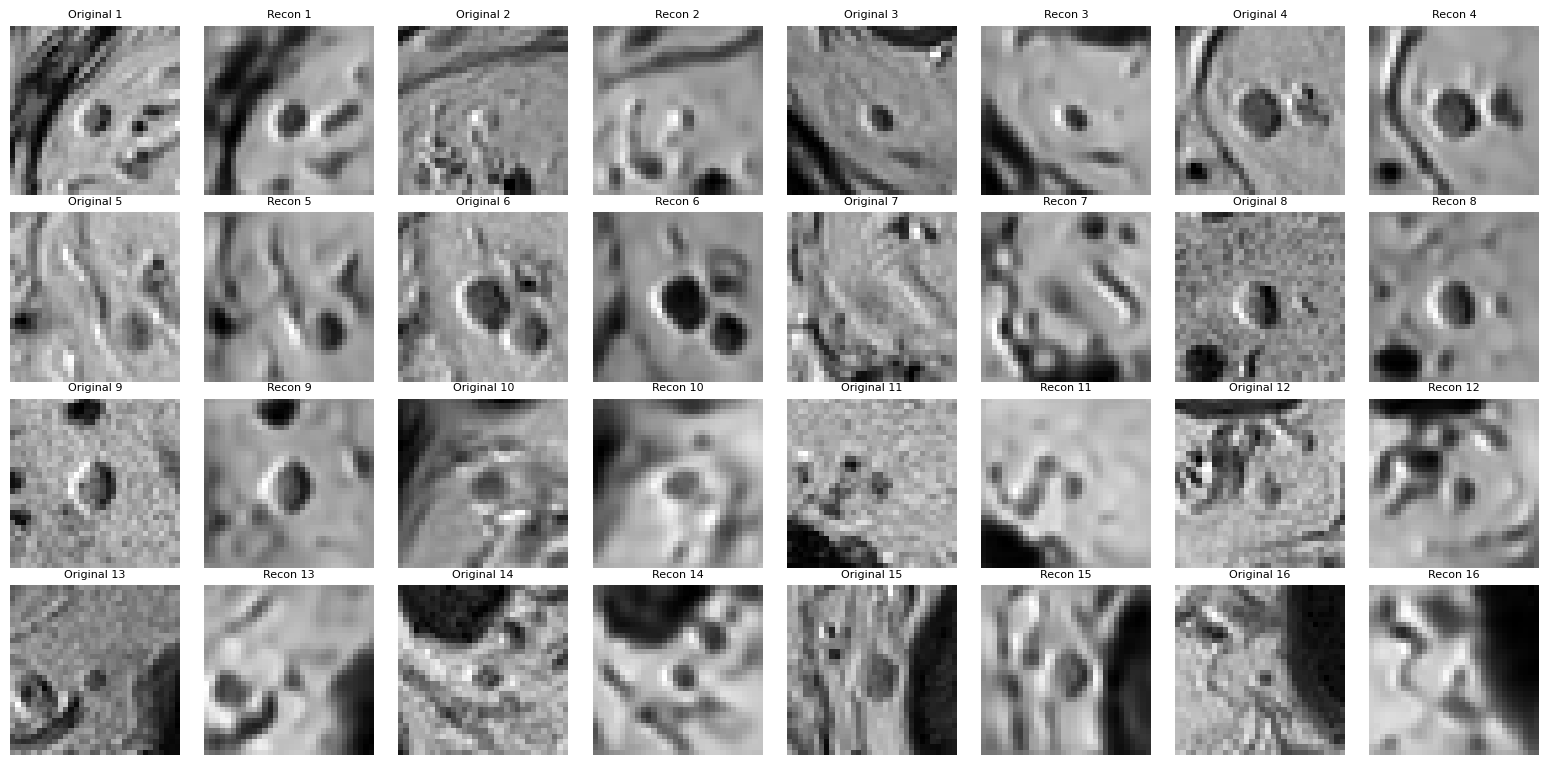

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyperparams = checkpoint['hyperparams']
model = VAE_2D(hyperparams)
model = model.to(device)

# Load the saved checkpoint
model.load_state_dict(checkpoint["state_dict"])

# Put the model into evaluation mode if you're not training anymore
model.eval()

#encoder = model.encoder

train_dataset = LoadImages(main_dir=IMAGE_DIR + '/', files_list=train_images)
test_dataset = LoadImages(main_dir=IMAGE_DIR + '/', files_list=test_images)
train_loader = DataLoader(train_dataset, 1, shuffle=True)
test_loader = DataLoader(test_dataset, 1, shuffle=False)


original_images = []
reconstructed_images = []

# random seed
random.seed(40)

# Pick 16 random indices out of the 109 examples
random_indices = random.sample(range(109), 16)

# With no gradients, gather reconstructions
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        if batch_idx in random_indices:
            # Pass the data through the model to get reconstructions
            recons, mu, log_var = model(data.float().to(device))

            # Move to CPU and detach the tensors for display purposes
            original_images.append(data.squeeze().cpu().detach().numpy())
            reconstructed_images.append(recons.squeeze().cpu().detach().numpy())

        # Stop when we've gathered all 16
        if len(original_images) == 16:
            break


# Function to display original and reconstructed images side by side
def display_side_by_side(originals, recons):
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))  # 4 rows, 8 columns (4x2 pairs per row)

    for i in range(16):
        row = i // 4  # Row index
        col = (i % 4) * 2  # Column index, pair starts at even columns

        # Display original image
        axes[row, col].imshow(originals[i], cmap='gray')
        axes[row, col].axis('off')  # Remove axis ticks
        axes[row, col].set_title(f'Original {i+1}', fontsize=8)

        # Display reconstructed image next to the original
        axes[row, col + 1].imshow(recons[i], cmap='gray')
        axes[row, col + 1].axis('off')  # Remove axis ticks
        axes[row, col + 1].set_title(f'Recon {i+1}', fontsize=8)

    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Reduces horizontal and vertical space between images
    plt.show()

# Call the function to display images side by side
display_side_by_side(original_images, reconstructed_images)




# Create a directory to store the saved images if it doesn't exist
save_dir = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\image_saves"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to save original and reconstructed images
def save_images(originals, recons):
    for i in range(16):
        # Save original image
        plt.imsave(os.path.join(save_dir, f"original_{i+1}.png"), originals[i], cmap='gray')

        # Save reconstructed image
        plt.imsave(os.path.join(save_dir, f"reconstructed_{i+1}.png"), recons[i], cmap='gray')

# Call the function to save images
save_images(original_images, reconstructed_images)


### calculate reconstruction metrics for VAE

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from pytorch_msssim import ssim
import lpips 

# Initialize the LPIPS loss function
lpips_fn = lpips.LPIPS(net='alex').to(device)

# Assuming DataLoader and model are defined
train_loader = DataLoader(train_dataset, 25, shuffle=True)
test_loader = DataLoader(test_dataset, 25, shuffle=False)

# Lists to store the computed metrics
SSIM_list = []
MSE_list = []
L1_list = []
PSNR_list = []
LPIPS_list = []

# Define a function to calculate PSNR
def calculate_psnr(data, recon, max_value=1.0):
    mse = F.mse_loss(recon, data)
    psnr = 10 * torch.log10(max_value**2 / mse)
    return psnr

# Start evaluation loop
with torch.no_grad():
    for batch_idx, data in enumerate(train_loader):
        # Move data to the device (GPU/CPU)
        data = data.float().to(device)

        # Model inference (assuming `model` is defined and outputs reconstructions)
        reconstructions_batch, mu, log_var = model(data)

        # Calculate SSIM
        SSIM_batch = ssim(data, reconstructions_batch, data_range=1, nonnegative_ssim=True)
        SSIM_list.append(SSIM_batch.item())  # Convert tensor to a Python float

        # Calculate MSE
        MSE_batch = F.mse_loss(data, reconstructions_batch)
        MSE_list.append(MSE_batch.item())  # Convert tensor to a Python float

        # Calculate L1 Loss (MAE)
        L1_batch = F.l1_loss(data, reconstructions_batch)
        L1_list.append(L1_batch.item())

        # Calculate PSNR
        PSNR_batch = calculate_psnr(data, reconstructions_batch)
        PSNR_list.append(PSNR_batch.item())

        # Calculate LPIPS (Perceptual Loss)
        LPIPS_batch = lpips_fn(data, reconstructions_batch)
        LPIPS_list.append(LPIPS_batch.mean().item())  # LPIPS returns a batch, we take the mean

# The lists SSIM_list, MSE_list, L1_list, PSNR_list, and LPIPS_list will contain the metrics for all batches.
print('Mean Squared Error', np.mean(MSE_list))
print('Mean Absolute Error', np.mean(L1_list))
print('Mean SSIM', np.mean(SSIM_list))
print('Mean PSNR', np.mean(PSNR_list))
print('Mean LPIPS', np.mean(LPIPS_list))

# Test
# Mean Squared Error 0.0023503529536537827
# Mean Absolute Error 0.03474433362483978
# Mean SSIM 0.7891667461395264
# Mean PSNR 26.595578079223632
# Mean LPIPS 0.03628578804433346

# Train
# Mean Squared Error 0.0020310759058283457
# Mean Absolute Error 0.03193602186338911
# Mean SSIM 0.7958701722405606
# Mean PSNR 26.97091393551584
# Mean LPIPS 0.04368896565491989

#### 6. Statistics on validation sample for lymph node annotations. Checked by consultant GI radiologist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
all_files_list = ['\mri' + '//' + f for f in os.listdir(IMAGE_DIR + '\mri')] + ['\mri_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mri_aug')]
all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)
all_files = []
for file in all_files_list:
    all_files.append(file.split('//')[1].split('mri')[0] + 'mask.nii')

bounding_boxes = np.load(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\bounding_boxes2.npy", allow_pickle=True).item()

checked_scans = ['4C9ACC08D3', '4EFA437AB2', '5AB09B0107', '5B56BA78BF', '6FAE8E26F6', '8E83AEB068', '9B668251C3', '11F4B52B63', 'B7B5DB41AB', '24D14FE845', '55AE53BCBB', '99F1D60B6B', '534EDC5F20', '567AF45838', '577AC5AE1E', '578AA620B5', '811B9DB031', 'B2E37AB4E6', 'A97FBCB15D', 'D2A1436101', 'C62CD9913B', 'D8B82BC2A1', 'F7C346CFF8', 'E5D6E0858B', 'FEDD490BC2', 'DD485FA12A', 'DE9FAF6FCC', 'F0E9BDB23F', 'E9FB632C90', '8603BEA42B', 'A589FC5847', 'AB30291317', '3975724E9F', 'A75FAB9893']

sizes_dict = {i:0 for i in range(1, 5)}
number_of_nodes = []
total_in_sample = 0
for patient in bounding_boxes.items():
    bboxes = patient[1]
    for node in bboxes:
        sizes_dict[bboxes[node]['size'][0]] += 1

    for scan in checked_scans:
        if scan in patient[0] and patient[0].split('\\')[-1] in all_files:
            print(patient[0])
            for node in bboxes:
                total_in_sample += 1



    number_of_nodes.append(len(bboxes))
    
    


print('Total in sample:', total_in_sample)

# def plot_slice_distribution(slice_counts):
#     plt.hist(slice_counts, bins=range(1, max(slice_counts) + 2), align='left', rwidth=0.8)
#     plt.xlabel('Number of Slices')
#     plt.ylabel('Number of Objects')
#     plt.title('Distribution of Number of Slices per Object')
#     plt.xticks(range(1, max(slice_counts) + 1))
#     plt.show()
# 
# plot_slice_distribution(slice_counts)
print('mean', np.mean(number_of_nodes), 'std', np.std(number_of_nodes))
#Total in sample: 271
#mean 5.868421052631579 std 3.8166605176417256